In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from google.colab import drive
import os
import re
import torch

tqdm.pandas()

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Capstone_design/")

Mounted at /content/drive


## Load Data

In [ ]:
train_df = pd.read_csv("SBIC.v2.agg.trn.csv")
val_df = pd.read_csv("SBIC.v2.agg.dev.csv")
test_df = pd.read_csv("SBIC.v2.agg.tst.csv")

In [ ]:
train_dy_metrics = pd.read_csv("train_dy_metrics.csv").drop("index", axis=1)
temp = train_dy_metrics.copy()

In [ ]:
temp = temp.sort_values(by="guid")
temp["offensiveYN"] = train_df["offensiveYN"].values
temp["abs_offensiveYN"] = abs(temp["offensiveYN"]-0.5)

In [ ]:
n_samples = int(len(train_dy_metrics)/3)
temp = temp.sort_values(by=["confidence"],ascending=False)[:n_samples]
temp

,guid,threshold_closeness,confidence,variability,correctness,forgetfulness,offensiveYN,abs_offensiveYN
25806,33359,0.058641,0.937446,0.030329,4,0,0.000000,0.500000
32188,24117,0.064282,0.930950,0.024372,4,0,0.000000,0.500000
31938,13448,0.064705,0.930459,0.034707,4,0,0.000000,0.500000
32965,703,0.064917,0.930213,0.022128,4,0,0.666667,0.166667
31167,17792,0.064922,0.930207,0.025687,4,0,0.000000,0.500000
...,...,...,...,...,...,...,...,...
27397,2499,0.185139,0.754679,0.171717,3,0,0.000000,0.500000
29006,7549,0.185143,0.754671,0.176687,3,0,1.000000,0.500000
3498,32355,0.185149,0.754659,0.183933,3,0,0.333333,0.166667
28444,6334,0.185152,0.754653,0.036411,4,0,1.000000,0.500000


In [ ]:
train_dy_metrics_off = train_dy_metrics.merge(train_df["offensiveYN"], left_on="guid", right_on=train_df["offensiveYN"].index)
train_dy_metrics_off["abs_offensiveYN"] = train_dy_metrics_off["offensiveYN"].apply(lambda x : abs(x-0.5))
train_dy_metrics_off

,guid,threshold_closeness,confidence,variability,correctness,forgetfulness,offensiveYN,abs_offensiveYN
0,22749,0.179411,0.765686,0.074966,4,0,0.500000,0.000000
1,12186,0.188648,0.252307,0.058964,0,1000,0.333333,0.166667
2,19868,0.202609,0.282305,0.060212,0,1000,0.333333,0.166667
3,30023,0.185901,0.753178,0.236622,3,0,0.000000,0.500000
4,33539,0.228693,0.645971,0.196670,3,0,0.166667,0.333333
...,...,...,...,...,...,...,...,...
35419,32637,0.241946,0.410256,0.160799,1,0,0.333333,0.166667
35420,21934,0.194674,0.735214,0.174907,3,1,0.000000,0.500000
35421,30634,0.111177,0.872589,0.030262,4,0,1.000000,0.500000
35422,5705,0.249376,0.524983,0.174246,3,1,0.333333,0.166667


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

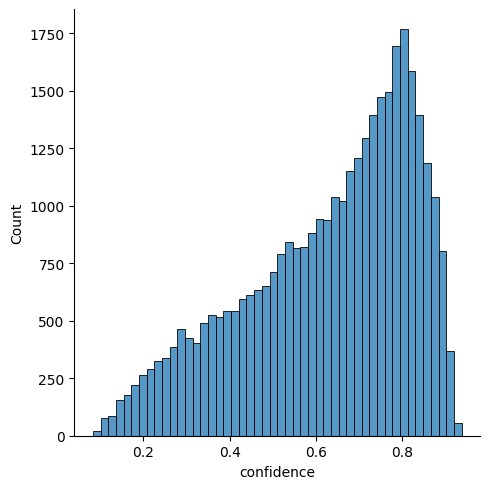

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.displot(x=train_dy_metrics_off["confidence"])
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

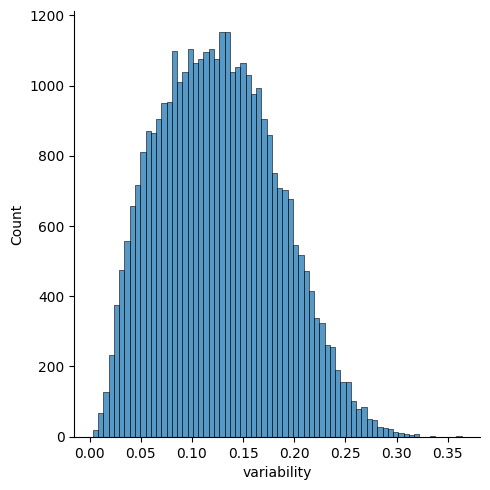

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.displot(x=train_dy_metrics_off["variability"])
plt.figure()

In [ ]:
easy = train_dy_metrics_off.loc[train_dy_metrics_off["confidence"] >= 0.6]
not_easy = train_dy_metrics_off.loc[train_dy_metrics_off["confidence"] <= 0.6]
not_easy

,guid,threshold_closeness,confidence,variability,correctness,forgetfulness,offensiveYN,abs_offensiveYN
1,12186,0.188648,0.252307,0.058964,0,1000,0.333333,0.166667
2,19868,0.202609,0.282305,0.060212,0,1000,0.333333,0.166667
6,12097,0.243569,0.580196,0.247540,2,0,0.000000,0.500000
8,1176,0.244801,0.427896,0.243892,2,2,0.500000,0.000000
10,3812,0.249008,0.531490,0.220804,2,0,0.333333,0.166667
...,...,...,...,...,...,...,...,...
35408,6761,0.118047,0.136747,0.012709,0,1000,0.000000,0.500000
35414,18872,0.239041,0.395314,0.111774,1,1,0.833333,0.333333
35419,32637,0.241946,0.410256,0.160799,1,0,0.333333,0.166667
35422,5705,0.249376,0.524983,0.174246,3,1,0.333333,0.166667


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

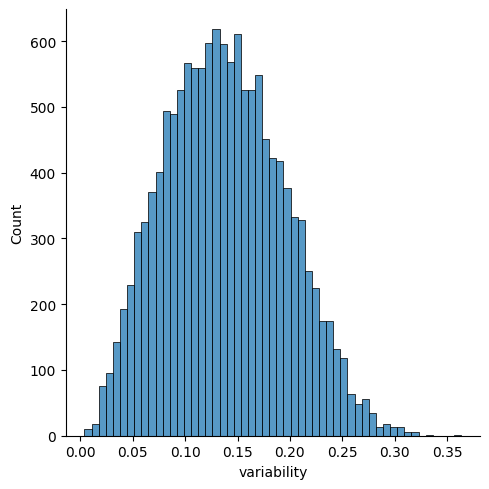

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.displot(x=not_easy["variability"])
plt.figure()

In [ ]:
train_dy_metrics_off.sort_values(by="confidence", ascending=False)

,guid,threshold_closeness,confidence,variability,correctness,forgetfulness,offensiveYN,abs_offensiveYN
25806,33359,0.058641,0.937446,0.030329,4,0,0.000000,0.500000
32188,24117,0.064282,0.930950,0.024372,4,0,0.000000,0.500000
31938,13448,0.064705,0.930459,0.034707,4,0,0.000000,0.500000
32965,703,0.064917,0.930213,0.022128,4,0,0.666667,0.166667
31167,17792,0.064922,0.930207,0.025687,4,0,0.000000,0.500000
...,...,...,...,...,...,...,...,...
31918,19367,0.082499,0.090731,0.020534,0,1000,0.166667,0.333333
20654,24032,0.079367,0.086923,0.031909,0,1000,0.000000,0.500000
28332,13261,0.077785,0.085012,0.036320,0,1000,0.666667,0.166667
33885,35186,0.076892,0.083937,0.033345,0,1000,0.500000,0.000000


In [ ]:
n_samples = int(len(train_dy_metrics)/3)

easy = train_dy_metrics_off.sort_values(by=["confidence"],ascending=False)[:n_samples].copy()
not_easy = train_dy_metrics_off.sort_values(by=["confidence"],ascending=False)[n_samples:].copy()
ambiguous = not_easy.sort_values(by=["variability"],ascending=False)[:n_samples].copy()
hard = not_easy.sort_values(by=["variability"],ascending=False)[n_samples:].copy()

In [ ]:
print("Average agreement of easy : {:0.2f} , variance {:0.2f}".format(easy["abs_offensiveYN"].mean(), easy["abs_offensiveYN"].var()))
print("Average agreement of ambiguous : {:0.2f} , variance {:0.2f}".format(ambiguous["abs_offensiveYN"].mean(), ambiguous["abs_offensiveYN"].var()))
print("Average agreement of hard : {:0.2f} , variance {:0.2f}".format(hard["abs_offensiveYN"].mean(), hard["abs_offensiveYN"].var()))

Average agreement of easy : 0.44 , variance 0.02
Average agreement of ambiguous : 0.39 , variance 0.03
Average agreement of hard : 0.37 , variance 0.03


In [ ]:
temp["abs_offensiveYN"].values == easy["abs_offensiveYN"].values

array([ True,  True,  True, ...,  True,  True,  True])

<Figure size 640x480 with 0 Axes>

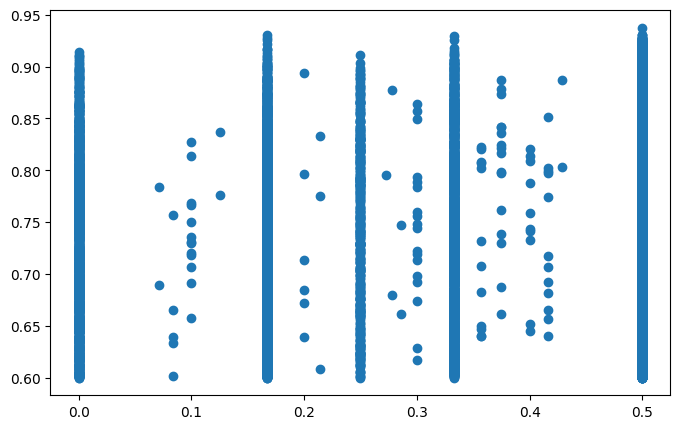

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.scatter(x=easy["abs_offensiveYN"], y=easy["confidence"])
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

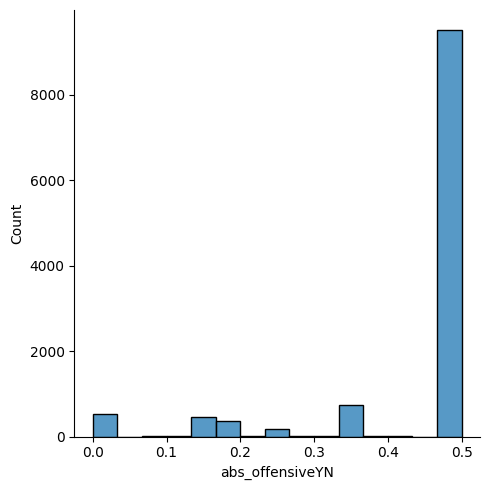

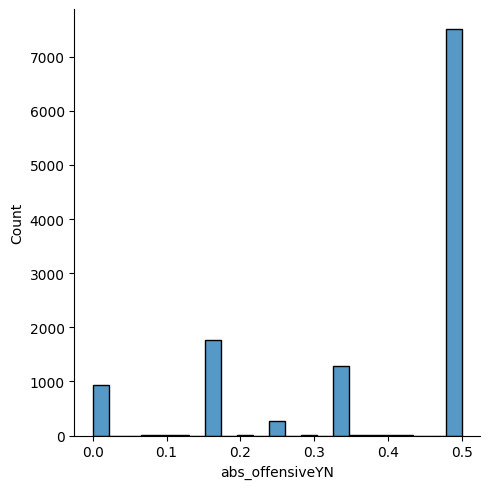

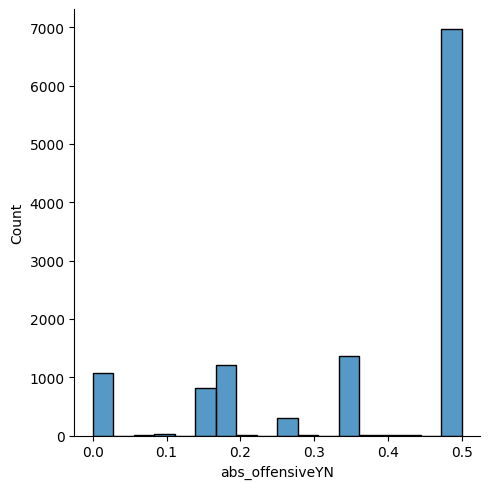

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
sns.displot(x=easy["abs_offensiveYN"])
sns.displot(x=ambiguous["abs_offensiveYN"])
sns.displot(x=hard["abs_offensiveYN"])
plt.figure()